# Conjugate Priors

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapters we have used grid approximations to solve a variety of problems.
One of my goals has been to show that this approach is sufficient to solve many real-world problems.
And I think it's a good place to start because it shows clearly how the methods work.

However, as we saw in the previous chapter, grid methods will only get you so far.
As we increase the number of parameters, the number of points in the grid grows (literally) exponentially.
With more than 3-4 parameters, grid methods become impractical.

So, in the remaining three chapters, I will present three alternatives:

1. In this chapter we'll use **conjugate priors** to speed up some of the computations we've already done.

2. In the next chapter, I'll present Markov chain Monte Carlo (MCMC) methods, which can solve problems with tens of parameters, or even hundreds, in a reasonable amount of time.

3. And in the last chapter we'll use Approximate Bayesian Computation (ABC) for problems that are hard to model with simple distributions.

We'll start with the World Cup problem.

在前面的章节中，我们使用网格近似来解决各种问题。
我的目标之一是证明这种方法足以解决许多现实世界的问题。
我认为这是一个很好的起点，因为它清楚地显示了这些方法是如何工作的。

然而，正如我们在前一章中看到的，网格方法只能让你走这么远。
随着参数数量的增加，网格中的点数（字面上）呈指数增长。
使用超过 3-4 个参数，网格方法变得不切实际。

因此，在剩下的三章中，我将介绍三个备选方案：

1. 在本章中，我们将使用 **conjugate priors** 来加速我们已经完成的一些计算。

2. 在下一章中，我将介绍马尔可夫链蒙特卡罗（MCMC）方法，它可以在合理的时间内解决数十个甚至数百个参数的问题。

3. 在最后一章中，我们将使用近似贝叶斯计算 (ABC) 来解决难以用简单分布建模的问题。

我们将从世界杯问题开始。

## The World Cup Problem Revisited

In <<_PoissonProcesses>>, we solved the World Cup problem using a Poisson process to model goals in a soccer game as random events that are equally likely to occur at any point during a game.

We used a gamma distribution to represent the prior distribution of $\lambda$, the goal-scoring rate.  And we used a Poisson distribution to compute the probability of $k$, the number of goals scored.

Here's a gamma object that represents the prior distribution.

## 世界杯问题重温

在 <<_PoissonProcesses>> 中，我们使用泊松过程将足球比赛中的目标建模为在比赛期间的任何时候同样可能发生的随机事件，从而解决了世界杯问题。

我们使用 gamma 分布来表示 $\lambda$ 的先验分布，即进球得分率。我们使用泊松分布来计算 $k$ 的概率，即进球数。

这是一个表示先验分布的伽马对象。

In [3]:
from scipy.stats import gamma

alpha = 1.4
dist = gamma(alpha)

In [5]:
dist

And here's a grid approximation.

In [43]:
import numpy as np
from utils import pmf_from_dist

lams = np.linspace(0, 10, 101)
prior = pmf_from_dist(dist, lams)
prior

,probs
0.0,0.000000
0.1,0.041053
0.2,0.049015
0.3,0.052160
0.4,0.052952
...,...
9.6,0.000019
9.7,0.000017
9.8,0.000016
9.9,0.000014


Here's the likelihood of scoring 4 goals for each possible value of `lam`.

这是每个可能的 `lam` 值进 4 球的可能性。

In [7]:
from scipy.stats import poisson

k = 4
likelihood = poisson(lams).pmf(k)

And here's the update.

In [8]:
posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

So far, this should be familiar.
Now we'll solve the same problem using the conjugate prior.

到目前为止，这应该是熟悉的。
现在我们将使用共轭先验来解决同样的问题。

## The Conjugate Prior

In <<_TheGammaDistribution>>, I presented three reasons to use a gamma distribution for the prior and said there was a fourth reason I would reveal later.
Well, now is the time.

The other reason I chose the gamma distribution is that it is the "conjugate prior" of the Poisson distribution, so-called because the two distributions are connected or coupled, which is what "conjugate" means.

In the next section I'll explain *how* they are connected, but first I'll show you the consequence of this connection, which is that there is a remarkably simple way to compute the posterior distribution.

However, in order to demonstrate it, we have to switch from the one-parameter version of the gamma distribution to the two-parameter version.  Since the first parameter is called `alpha`, you might guess that the second parameter is called `beta`.

The following function takes `alpha` and `beta` and makes an object that represents a gamma distribution with those parameters.

## 共轭先验

在 <<_TheGammaDistribution>> 中，我提出了使用 gamma 分布作为先验的三个原因，并说还有第四个原因，我稍后会透露。
嗯，现在是时候了。

我选择伽玛分布的另一个原因是它是泊松分布的“共轭先验”，之所以这么说是因为这两个分布是连接或耦合的，这就是“共轭”的意思。

在下一节中，我将解释*如何*它们连接，但首先我将向您展示这种连接的结果，即有一种非常简单的方法可以计算后验分布。

但是，为了演示它，我们必须从伽马分布的单参数版本切换到双参数版本。由于第一个参数称为“alpha”，您可能会猜到第二个参数称为“beta”。

下面的函数接受 `alpha` 和 `beta` 并创建一个表示具有这些参数的 gamma 分布的对象。

In [10]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

Here's the prior distribution with `alpha=1.4` again and `beta=1`. 

这是再次使用 `alpha=1.4` 和 `beta=1` 的先验分布。

In [11]:
alpha = 1.4
beta = 1

prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

1.4

In [14]:
prior_gamma.beta

1

Now I claim without proof that we can do a Bayesian update with `k` goals just by making a gamma distribution with parameters `alpha+k` and `beta+1`.

现在我在没有证据的情况下声称我们可以通过使用参数 `alpha+k` 和 `beta+1` 进行 gamma 分布来使用`k` 目标进行贝叶斯更新。

In [12]:
def update_gamma(prior, data):
    """Update a gamma prior."""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta) ### 生成gamma分布

Here's how we update it with `k=4` goals in `t=1` game.

In [16]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

After all the work we did with the grid, it might seem absurd that we can do a Bayesian update by adding two pairs of numbers.
So let's confirm that it works.

I'll make a `Pmf` with a discrete approximation of the posterior distribution.

In [17]:
posterior_conjugate = pmf_from_dist(posterior_gamma, lams)

The following figure shows the result along with the posterior we computed using the grid algorithm.

In [18]:
from utils import decorate

def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
             ylabel='PMF',
             title=title)

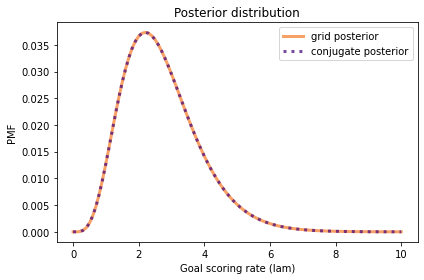

In [19]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior', 
                         color='C4', ls=':')

decorate_rate('Posterior distribution')

They are the same other than small differences due to floating-point approximations.
它们是相同的，除了由于浮点近似引起的细微差别之外

In [20]:
np.allclose(posterior, posterior_conjugate)

True

> 思路：
原本的先验是gama分布，然后计算似然是泊松分布，然后相乘，现在直接使用gamma分布，然后初始化数字为1和1，然后改变beta和alpha，就是加上数字

## What the Actual?

To understand how that works, we'll write the PDF of the gamma prior and the PMF of the Poisson likelihood, then multiply them together, because that's what the Bayesian update does.
We'll see that the result is a gamma distribution, and we'll derive its parameters.

Here's the PDF of the gamma prior, which is the probability density for each value of $\lambda$, given parameters $\alpha$ and $\beta$:

$$\lambda^{\alpha-1} e^{-\lambda \beta}$$

I have omitted the normalizing factor; since we are planning to normalize the posterior distribution anyway, we don't really need it.

Now suppose a team scores $k$ goals in $t$ games.
The probability of this data is given by the PMF of the Poisson distribution, which is a function of $k$ with $\lambda$ and $t$ as parameters.

$$\lambda^k e^{-\lambda t}$$

Again, I have omitted the normalizing factor, which makes it clearer that the gamma and Poisson distributions have the same functional form.
When we multiply them together, we can pair up the factors and add up the exponents.
The result is the unnormalized posterior distribution,

$$\lambda^{\alpha-1+k} e^{-\lambda(\beta + t)}$$

which we can recognize as an unnormalized gamma distribution with parameters $\alpha + k$ and $\beta + t$.

This derivation provides insight into what the parameters of the posterior distribution mean: $\alpha$ reflects the number of events that have occurred; $\beta$ reflects the elapsed time.

## 实际情况如何？

为了理解它是如何工作的，我们将编写伽马先验的 PDF 和泊松似然的 PMF，然后将它们相乘，因为这就是贝叶斯更新所做的。
我们将看到结果是一个伽马分布，我们将推导出它的参数。

这是 gamma 先验的 PDF，它是给定参数 $\alpha$ 和 $\beta$ 的每个 $\lambda$ 值的概率密度：

$$\lambda^{\alpha-1} e^{-\lambda \beta}$$

我省略了归一化因子；因为无论如何我们都计划对后验分布进行归一化，所以我们并不需要它。

现在假设一支球队在 $t$ 场比赛中得分 $k$。
该数据的概率由 Poisson 分布的 PMF 给出，它是以 $\lambda$ 和 $t$ 作为参数的 $k$ 的函数。

$$\lambda^k e^{-\lambda t}$$

同样，我省略了归一化因子，这更清楚地表明 gamma 和 Poisson 分布具有相同的函数形式。
当我们将它们相乘时，我们可以将因子配对并将指数相加。
结果是未归一化的后验分布，

$$\lambda^{\alpha-1+k} e^{-\lambda(\beta + t)}$$

我们可以将其识别为具有参数 $\alpha + k$ 和 $\beta + t$ 的非归一化 gamma 分布。

这个推导提供了对后验分布参数含义的洞察：$\alpha$ 反映了已发生的事件数量； $\beta$ 反映了经过的时间。

## Binomial Likelihood

As a second example, let's look again at the Euro problem.
When we solved it with a grid algorithm, we started with a uniform prior:
作为第二个例子，让我们再来看看欧元问题。当我们用网格算法解决这个问题时，我们从一个统一的先验开始:

In [32]:
from utils import make_uniform

xs = np.linspace(0, 1, 101)
uniform = make_uniform(xs, 'uniform')

We used the binomial distribution to compute the likelihood of the data, which was 140 heads out of 250 attempts.

我们使用二项分布来计算数据的可能性，这是250次尝试中的140次。

In [33]:
from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs
likelihood = binom.pmf(k, n, xs)

Then we computed the posterior distribution in the usual way.

In [34]:
posterior = uniform * likelihood
posterior.normalize()

0.003944617569326651

We can solve this problem more efficiently using the conjugate prior of the binomial distribution, which is the beta distribution.

The beta distribution is bounded between 0 and 1, so it works well for representing the distribution of a probability like `x`.
It has two parameters, called `alpha` and `beta`, that determine the shape of the distribution.

SciPy provides an object called `beta` that represents a beta distribution.
The following function takes `alpha` and `beta` and returns a new `beta` object.

我们可以使用二项分布的共轭先验更有效地解决这个问题，也就是 beta 分布。

beta 分布在 0 和 1 之间，因此它可以很好地表示像“x”这样的概率分布。
它有两个参数，称为“alpha”和“beta”，它们决定了分布的形状。

SciPy 提供了一个名为“beta”的对象，它代表了一个 beta 分布。
下面的函数接受 `alpha` 和 `beta` 并返回一个新的 `beta` 对象。

In [35]:
import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object."""
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

It turns out that the uniform distribution, which we used as a prior, is the beta distribution with parameters `alpha=1` and `beta=1`.
So we can make a `beta` object that represents a uniform distribution, like this:

事实证明，我们作为先验使用的均匀分布是带有参数 `alpha=1` 和 `beta=1` 的 beta 分布。
所以我们可以制作一个表示均匀分布的“beta”对象，如下所示：

In [36]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)

Now let's figure out how to do the update.  As in the previous example, we'll write the PDF of the prior distribution and the PMF of the likelihood function, and multiply them together.  We'll see that the product has the same form as the prior, and we'll derive its parameters.

Here is the PDF of the beta distribution, which is a function of $x$ with $\alpha$ and $\beta$ as parameters.

$$x^{\alpha-1} (1-x)^{\beta-1}$$

Again, I have omitted the normalizing factor, which we don't need because we are going to normalize the distribution after the update.

And here's the PMF of the binomial distribution, which is a function of $k$ with $n$ and $x$ as parameters.

$$x^{k} (1-x)^{n-k}$$

Again, I have omitted the normalizing factor.
Now when we multiply the beta prior and the binomial likelihood, the result is

$$x^{\alpha-1+k} (1-x)^{\beta-1+n-k}$$

which we recognize as an unnormalized beta distribution with parameters $\alpha+k$ and $\beta+n-k$.

So if we observe `k` successes in `n` trials, we can do the update by making a beta distribution with parameters `alpha+k` and `beta+n-k`.
That's what this function does:

现在让我们弄清楚如何进行更新。与前面的示例一样，我们将编写先验分布的 PDF 和似然函数的 PMF，并将它们相乘。我们将看到产品具有与先前相同的形式，我们将推导出它的参数。

这是 beta 分布的 PDF，它是一个以 $\alpha$ 和 $\beta$ 为参数的 $x$ 的函数。

$$x^{\alpha-1} (1-x)^{\beta-1}$$

同样，我省略了我们不需要的归一化因子，因为我们将在更新后对分布进行归一化。

这是二项分布的 PMF，它是 $k$ 的函数，以 $n$ 和 $x$ 作为参数。

$$x^{k} (1-x)^{n-k}$$

同样，我省略了归一化因子。
现在，当我们将 beta 先验和二项式似然相乘时，结果是

$$x^{\alpha-1+k} (1-x)^{\beta-1+n-k}$$

我们将其识别为具有参数 $\alpha+k$ 和 $\beta+n-k$ 的非归一化 beta 分布。

因此，如果我们在 n 次试验中观察到 k 次成功，我们可以通过使用参数 alpha+k 和 beta+n-k 制作 beta 分布来进行更新。
这就是这个函数的作用：

In [37]:
def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

Again, the conjugate prior gives us insight into the meaning of the parameters; $\alpha$ is related to the number of observed successes; $\beta$ is related to the number of failures.

Here's how we do the update with the observed data.

同样，共轭先验让我们深入了解参数的含义； $\alpha$ 与观察到的成功次数有关； $\beta$ 与失败次数有关。

以下是我们如何使用观察到的数据进行更新。

In [38]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)

To confirm that it works, I'll evaluate the posterior distribution for the possible values of `xs` and put the results in a `Pmf`.

为了确认它有效，我将评估 `xs` 的可能值的后验分布，并将结果放入 `Pmf` 中。

In [39]:
posterior_conjugate = pmf_from_dist(posterior_beta, xs)

And we can compare the posterior distribution we just computed with the results from the grid algorithm.

我们可以将刚刚计算的后验分布与网格算法的结果进行比较。

In [40]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

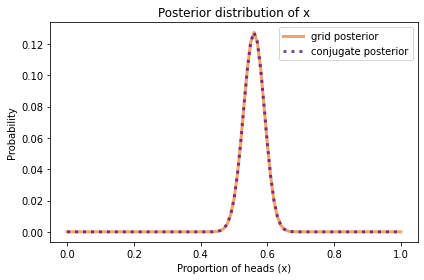

In [41]:
posterior.plot(label='grid posterior', color='C1')
posterior_conjugate.plot(label='conjugate posterior',
                        color='C4', ls=':')

decorate_euro(title='Posterior distribution of x')

>思路:
开始的话用的是先验是平均分布，然后使用成功失败的数据作为二项分布的数据二项生成似然，计算平均分布和二项分布的乘积，然后现在的先验就是alpha = 1
beta = 1，的beta分布，然后只需要把beta分布的参数加失败成功的次数就生成了新的beta分布

They are the same other than small differences due to floating-point approximations.

The examples so far are problems we have already solved, so let's try something new.

除了由于浮点近似导致的微小差异之外，它们是相同的。

到目前为止的例子都是我们已经解决的问题，所以让我们尝试一些新的东西。

In [42]:
np.allclose(posterior, posterior_conjugate)

True

## Lions and Tigers and Bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
During the tour, we see 3 lions, 2 tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, what is the probability that the next animal we see is a bear?

To answer this question, we'll use the data to estimate the prevalence of each species, that is, what fraction of the animals belong to each species.
If we know the prevalences, we can use the multinomial distribution to compute the probability of the data.
For example, suppose we know that the fraction of lions, tigers, and bears is 0.4, 0.3, and 0.3, respectively.

In that case the probability of the data is:


## 狮子、老虎和熊

假设我们参观了一个野生动物保护区，在那里我们知道唯一的动物是狮子、老虎和熊，但我们不知道每种动物有多少。
在游览过程中，我们看到了 3 只狮子、2 只老虎和 1 只熊。 假设每只动物出现在我们的样本中的机会均等，那么我们看到的下一个动物是熊的概率是多少？

为了回答这个问题，我们将使用数据来估计每个物种的流行程度，即每个物种的动物比例。
如果我们知道普遍性，我们可以使用多项分布来计算数据的概率。
例如，假设我们知道狮子、老虎和熊的比例分别为 0.4、0.3 和 0.3。

在这种情况下，数据的概率为：

In [45]:
from scipy.stats import multinomial

data = 3, 2, 1
n = np.sum(data)
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

0.10368

Now, we could choose a prior for the prevalences and do a Bayesian update using the multinomial distribution to compute the probability of the data.

But there's an easier way, because the multinomial distribution has a conjugate prior: the Dirichlet distribution.

现在，我们可以为流行率选择一个先验，并使用多项分布进行贝叶斯更新来计算数据的概率。

但是有一种更简单的方法，因为多项分布有一个共轭先验：Dirichlet 分布。

## The Dirichlet Distribution

The Dirichlet distribution is a multivariate distribution, like the multivariate normal distribution we used in <<_MultivariateNormalDistribution>> to describe the distribution of penguin measurements.  

In that example, the quantities in the distribution are pairs of flipper length and culmen length, and the parameters of the distribution are a vector of means and a matrix of covariances.

In a Dirichlet distribution, the quantities are vectors of probabilities, $\mathbf{x}$, and the parameter is a vector, $\mathbf{\alpha}$.

An example will make that clearer.  SciPy provides a `dirichlet` object that represents a Dirichlet distribution.
Here's an instance with $\mathbf{\alpha} = 1, 2, 3$.


## 狄利克雷分布

狄利克雷分布是一个多元分布，就像我们在<<_MultivariateNormalDistribution>>中用来描述企鹅测量值分布的多元正态分布。

在该示例中，分布中的数量是成对的鳍状肢长度和顶棚长度，分布的参数是均值向量和协方差矩阵。

在狄利克雷分布中，数量是概率向量 $\mathbf{x}$，参数是向量 $\mathbf{\alpha}$。

一个例子会更清楚地说明这一点。 SciPy 提供了一个表示 Dirichlet 分布的“dirichlet”对象。
这是一个 $\mathbf{\alpha} = 1, 2, 3$ 的实例。

In [44]:
from scipy.stats import dirichlet

alpha = 1, 2, 3
dist = dirichlet(alpha)

Since we provided three parameters, the result is a distribution of three variables.
If we draw a random value from this distribution, like this:

由于我们提供了三个参数，因此结果是三个变量的分布。
如果我们从这个分布中抽取一个随机值，像这样：

In [46]:
dist.rvs()

array([[0.03902164, 0.62242822, 0.33855014]])

In [47]:
dist.rvs().sum()

1.0

The result is an array of three values. 
They are bounded between 0 and 1, and they always add up to 1, so they can be interpreted as the probabilities of a set of outcomes that are mutually exclusive and collectively exhaustive.

Let's see what the distributions of these values look like.  I'll draw 1000 random vectors from this distribution, like this:

结果是一个包含三个值的数组。
它们的界限在 0 和 1 之间，并且它们总是加起来为 1，因此它们可以被解释为一组相互排斥且共同穷举的结果的概率。

让我们看看这些值的分布是什么样的。 我将从这个分布中抽取 1000 个随机向量，如下所示：

In [48]:
sample = dist.rvs(1000)

In [49]:
sample.shape

(1000, 3)

The result is an array with 1000 rows and three columns.  I'll compute the `Cdf` of the values in each column.

结果是一个包含 1000 行和 3 列的数组。 我将计算每列中值的“Cdf”。

In [50]:
from empiricaldist import Cdf

cdfs = [Cdf.from_seq(col) 
        for col in sample.transpose()]

The result is a list of `Cdf` objects that represent the marginal distributions of the three variables.  Here's what they look like.
结果是代表三个变量的边际分布的“Cdf”对象列表。 这是他们的样子。

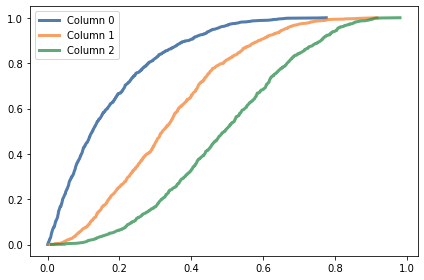

In [51]:
for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    cdf.plot(label=label)
    
decorate()

Column 0, which corresponds to the lowest parameter, contains the lowest probabilities.
Column 2, which corresponds to the highest parameter, contains the highest probabilities.

As it turns out, these marginal distributions are beta distributions.
The following function takes a sequence of parameters, `alpha`, and computes the marginal distribution of variable `i`:

对应于最低参数的第 0 列包含最低概率。
对应于最高参数的第 2 列包含最高概率。

事实证明，这些边际分布是 beta 分布。
以下函数采用一系列参数“alpha”，并计算变量“i”的边际分布：

In [52]:
def marginal_beta(alpha, i):
    """Compute the ith marginal of a Dirichlet distribution."""
    total = np.sum(alpha)
    return make_beta(alpha[i], total-alpha[i])

We can use it to compute the marginal distribution for the three variables.

我们可以用它来计算三个变量的边际分布。

In [54]:
marginals = [marginal_beta(alpha, i)
             for i in range(len(alpha))]

The following plot shows the CDF of these distributions as gray lines and compares them to the CDFs of the samples.

下图将这些分布的 CDF 显示为灰线，并将它们与样本的 CDF 进行比较。

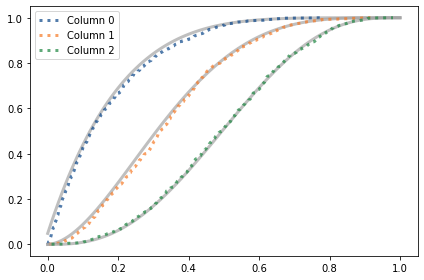

In [57]:
xs = np.linspace(0, 1, 101)

for i in range(len(alpha)):
    label = f'Column {i}'
    
    pmf = pmf_from_dist(marginals[i], xs)
    pmf.make_cdf().plot(color='C5')
    
    cdf = cdfs[i]
    cdf.plot(label=label, ls=':')

decorate()

This confirms that the marginals of the Dirichlet distribution are beta distributions.
And that's useful because the Dirichlet distribution is the conjugate prior for the multinomial likelihood function.

If the prior distribution is Dirichlet with parameter vector `alpha` and the data is a vector of observations, `data`, the posterior distribution is Dirichlet with parameter vector `alpha + data`.

As an exercise at the end of this chapter, you can use this method to solve the Lions and Tigers and Bears problem.

这证实了狄利克雷分布的边缘是贝塔分布。
这很有用，因为 Dirichlet 分布是多项似然函数的共轭先验。

如果先验分布是带有参数向量“alpha”的狄利克雷分布，并且数据是观察向量“data”，则后验分布是带有参数向量“alpha + data”的狄利克雷分布。

作为本章末尾的一个练习，你可以使用这个方法来解决狮子、老虎和熊的问题。

## Summary

After reading this chapter, if you feel like you've been tricked, I understand.  It turns out that many of the problems in this book can be solved with just a few arithmetic operations.  So why did we go to all the trouble of using grid algorithms?

Sadly, there are only a few problems we can solve with conjugate priors; in fact, this chapter includes most of the ones that are useful in practice.

For the vast majority of problems, there is no conjugate prior and no shortcut to compute the posterior distribution.
That's why we need grid algorithms and the methods in the next two chapters, Approximate Bayesian Computation (ABC) and Markov chain Monte Carlo methods (MCMC).

## 概括

看完这一章，如果你觉得自己被骗了，我理解。 事实证明，本书中的许多问题都可以通过几个算术运算来解决。 那么为什么我们要费尽心思使用网格算法呢？

可悲的是，我们只能用共轭先验解决几个问题。 事实上，本章包含了大部分在实践中有用的内容。

对于绝大多数问题，没有共轭先验，也没有计算后验分布的捷径。
这就是为什么我们需要网格算法和接下来两章中的方法，近似贝叶斯计算（ABC）和马尔可夫链蒙特卡罗方法（MCMC）。

## Exercises

**Exercise:** In the second version of the World Cup problem, the data we use for the update is not the number of goals in a game, but the time until the first goal.
So the probability of the data is given by the exponential distribution rather than the Poisson distribution. 

But it turns out that the gamma distribution is *also* the conjugate prior of the exponential distribution, so there is a simple way to compute this update, too.
The PDF of the exponential distribution is a function of $t$ with $\lambda$ as a parameter.

$$\lambda e^{-\lambda t}$$

Multiply the PDF of the gamma prior by this likelihood, confirm that the result is an unnormalized gamma distribution, and see if you can derive its parameters.

Write a few lines of code to update `prior_gamma` with the data from this version of the problem, which was a first goal after 11 minutes and a second goal after an additional 12 minutes.

## 练习

**练习：** 在第二版世界杯题中，我们用于更新的数据不是一场比赛的进球数，而是距离第一个进球的时间。
所以数据的概率是由指数分布而不是泊松分布给出的。

但事实证明，伽马分布*也是*指数分布的共轭先验，因此也有一种简单的方法来计算此更新。
指数分布的 PDF 是一个以 $\lambda$ 为参数的 $t$ 的函数。

$$\lambda e^{-\lambda t}$$

将 gamma 先验的 PDF 乘以这个可能性，确认结果是一个非标准化的 gamma 分布，看看你是否可以推导出它的参数。

编写几行代码，用这个版本的问题的数据更新 `prior_gamma`，这是 11 分钟后的第一个目标和额外 12 分钟后的第二个目标。

Remember to express these quantities in units of games, which are approximately 90 minutes.

请记住以游戏为单位表示这些数量，大约为 90 分钟。

The unnormalized posterior is

$$\lambda^{\alpha-1+1} e^{-(\beta + t) \lambda}$$

which is an unnormalized gamma distribution with parameters
`alpha+1` and `beta+t`, which means that we observed 1 goal
in elapsed time `t`.

So we can use the same update function and call it like this:
"""

In [58]:
# Solution goes here
data = 1, 11/90
posterior1 = update_gamma(prior_gamma, data)

In [59]:

# Solution goes here

data = 1, 12/90
posterior2 = update_gamma(posterior1, data)

In [60]:
# Solution goes here

prior_gamma.mean(), posterior1.mean(), posterior2.mean()

(1.4, 2.1386138613861387, 2.7079646017699113)

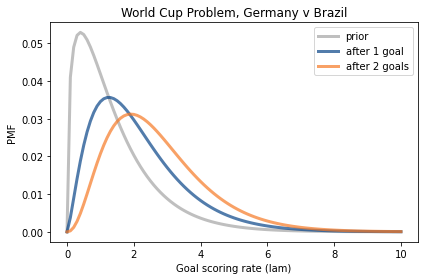

In [61]:
# Solution

# And here's what the posteriors look like

pmf_from_dist(prior_gamma, lams).plot(color='C5', label='prior')
pmf_from_dist(posterior1, lams).plot(label='after 1 goal')
pmf_from_dist(posterior2, lams).plot(label='after 2 goals')

decorate_rate(title='World Cup Problem, Germany v Brazil')

**Exercise:** For problems like the Euro problem where the likelihood function is binomial, we can do a Bayesian update with just a few arithmetic operations, but only if the prior is a beta distribution.

If we want a uniform prior, we can use a beta distribution with `alpha=1` and `beta=1`.
But what can we do if the prior distribution we want is not a beta distribution?
For example, in <<_TrianglePrior>> we also solved the Euro problem with a triangle prior, which is not a beta distribution.

In these cases, we can often find a beta distribution that is a good-enough approximation for the prior we want.
See if you can find a beta distribution that fits the triangle prior, then update it using `update_beta`.

Use `pmf_from_dist` to make a `Pmf` that approximates the posterior distribution and compare it to the posterior we just computed using a grid algorithm.  How big is the largest difference between them?

**练习：** 对于似然函数为二项式的欧元问题等问题，我们可以只用几个算术运算进行贝叶斯更新，但前提是先验是 beta 分布。

如果我们想要一个统一的先验，我们可以使用 alpha=1 和 beta=1 的 beta 分布。
但是，如果我们想要的先验分布不是 beta 分布，我们该怎么办？
例如，在 <<_TrianglePrior>> 中，我们还使用三角形先验解决了欧元问题，这不是 beta 分布。

在这些情况下，我们通常可以找到一个 beta 分布，它是我们想要的先验的足够好的近似值。
看看你是否能找到一个适合之前三角形的 beta 分布，然后使用 `update_beta` 对其进行更新。

使用 pmf_from_dist 制作一个近似后验分布的 Pmf ，并将其与我们刚刚使用网格算法计算的后验进行比较。 它们之间最大的区别有多大？

Here's the triangle prior again.
这是之前的三角形。

In [62]:
from empiricaldist import Pmf

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
xs = uniform.qs

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

And here's the update.

In [63]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

posterior = triangle * likelihood
posterior.normalize()

0.007008842590059086

To get you started, here's the beta distribution that we used as a uniform prior.

In [64]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

0.5

And here's what it looks like compared to the triangle prior.

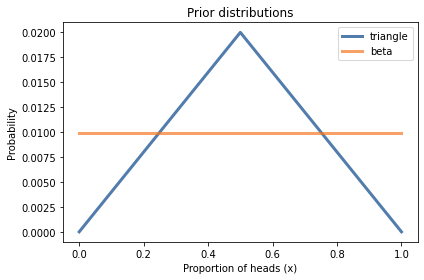

In [65]:
prior_pmf = pmf_from_dist(prior_beta, xs)

triangle.plot(label='triangle')
prior_pmf.plot(label='beta')

decorate_euro('Prior distributions')

Now you take it from there.

In [66]:
# Solution goes here

# Solution

data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

0.5595238095238095

In [67]:
# Solution goes here
posterior_conjugate = pmf_from_dist(posterior_beta, xs)

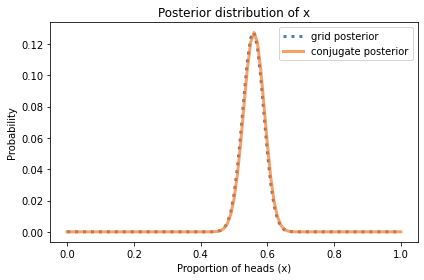

In [68]:
# Solution goes here

# Solution

posterior.plot(label='grid posterior', ls=':')
posterior_conjugate.plot(label='conjugate posterior')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Posterior distribution of x')

In [69]:
# Solution goes here

# Solution

# The largest absolute difference is pretty small

np.allclose(posterior, posterior_conjugate)

False

**Exercise:**  [3Blue1Brown](https://en.wikipedia.org/wiki/3Blue1Brown) is a YouTube channel about math; if you are not already aware of it, I recommend it highly.
In [this video](https://www.youtube.com/watch?v=8idr1WZ1A7Q) the narrator presents this problem:

> You are buying a product online and you see three sellers offering the same product at the same price.  One of them has a 100% positive rating, but with only 10 reviews.  Another has a 96% positive rating with 50 total reviews.  And yet another has a 93% positive rating, but with 200 total reviews.
>
>Which one should you buy from?

Let's think about how to model this scenario.  Suppose each seller has some unknown probability, `x`, of providing satisfactory service and getting a positive rating, and we want to choose the seller with the highest value of `x`.

This is not the only model for this scenario, and it is not necessarily the best.  An alternative would be something like item response theory, where sellers have varying ability to provide satisfactory service and customers have varying difficulty of being satisfied.

But the first model has the virtue of simplicity, so let's see where it gets us.

1. As a prior, I suggest a beta distribution with `alpha=8` and `beta=2`.  What does this prior look like and what does it imply about sellers?

2. Use the data to update the prior for the three sellers and plot the posterior distributions.  Which seller has the highest posterior mean?

3. How confident should we be about our choice?  That is, what is the probability that the seller with the highest posterior mean actually has the highest value of `x`?

4. Consider a beta prior with `alpha=0.7` and `beta=0.5`.  What does this prior look like and what does it imply about sellers?

5. Run the analysis again with this prior and see what effect it has on the results.

**练习：** [3Blue1Brown](https://en.wikipedia.org/wiki/3Blue1Brown) 是一个关于数学的 YouTube 频道；如果您还没有意识到它，我强烈推荐它。
在 [此视频](https://www.youtube.com/watch?v=8idr1WZ1A7Q) 中，叙述者提出了这个问题：

> 您在网上购买产品，您看到三个卖家以相同的价格提供相同的产品。其中一个有 100% 的正面评价，但只有 10 条评论。另一个有 96% 的正面评价，总共有 50 条评论。还有一个有 93% 的正面评价，但总共有 200 条评论。
>
>你应该从哪一个买？

让我们考虑如何对这种情况进行建模。假设每个卖家都有一些未知的概率“x”，提供满意的服务并获得正面评价，我们想选择“x”值最高的卖家。

这不是这种情况的唯一模型，也不一定是最好的。另一种选择是类似于项目响应理论，其中卖方提供令人满意的服务的能力不同，而客户获得满意的难度也不同。

但是第一个模型具有简单的优点，所以让我们看看它把我们带到了哪里。

1. 之前，我建议使用 `alpha=8` 和 `beta=2` 的 beta 发行版。这个先验是什么样的，它对卖家意味着什么？

2. 使用数据更新三个卖家的先验并绘制后验分布。哪个卖家的后验均值最高？

3. 我们应该对自己的选择有多大的信心？也就是说，具有最高后验均值的卖方实际上具有最高的“x”值的概率是多少？

4. 考虑 `alpha=0.7` 和 `beta=0.5` 的 beta 先验。这个先验是什么样的，它对卖家意味着什么？

5. 用这个先验再次运行分析，看看它对结果有什么影响。

Note: When you evaluate the beta distribution, you should restrict the range of `xs` so it does not include 0 and 1.  When the parameters of the beta distribution are less than 1, the probability density goes to infinity at 0 and 1.  From a mathematical point of view, that's not a problem; it is still a proper probability distribution.  But from a computational point of view, it means we have to avoid evaluating the PDF at 0 and 1. 

注意：评估 beta 分布时，应限制 `xs` 的范围，使其不包括 0 和 1。当 beta 分布的参数小于 1 时，概率密度在 0 和 1 处趋于无穷大。 从数学的角度来看，这不是问题。 它仍然是一个适当的概率分布。 但从计算的角度来看，这意味着我们必须避免在 0 和 1 处评估 PDF。

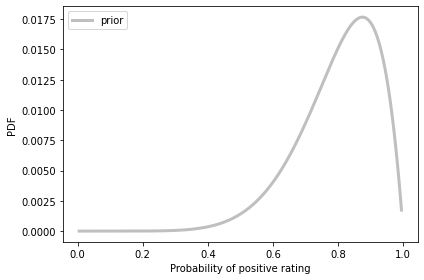

In [70]:
# Solution goes here
# Solution

# The first prior implies that most sellers are 
# satisfactory most of the time, but none are perfect.

prior = make_beta(8, 2)

xs = np.linspace(0.005, 0.995, 199)
prior_pmf = pmf_from_dist(prior, xs)
prior_pmf.plot(color='C5', label='prior')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF')

In [71]:
# Solution goes here

# Solution

data1 = 10, 10
data2 = 48, 50
data3 = 186, 200

In [72]:
# Solution goes here

# Solution

seller1 = update_beta(prior, data1)
seller2 = update_beta(prior, data2)
seller3 = update_beta(prior, data3)

In [73]:
# Solution goes here
# Solution

seller1_pmf = pmf_from_dist(seller1, xs)
seller2_pmf = pmf_from_dist(seller2, xs)
seller3_pmf = pmf_from_dist(seller3, xs)

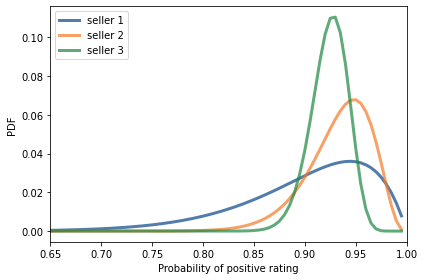

In [74]:
# Solution goes here
# Click to hide# Solution

seller1_pmf.plot(label='seller 1')
seller2_pmf.plot(label='seller 2')
seller3_pmf.plot(label='seller 3')

decorate(xlabel='Probability of positive rating',
         ylabel='PDF',
         xlim=(0.65, 1.0))

In [75]:
# Solution goes here
# Solution

seller1.mean(), seller2.mean(), seller3.mean()

(0.9, 0.9333333333333333, 0.9238095238095239)

In [76]:

# Click to hide# Solution

iters = 10000
a = np.empty((3, iters))

a[0] = seller1.rvs(iters)
a[1] = seller2.rvs(iters)
a[2] = seller3.rvs(iters)

In [77]:
# Solution goes here
# Click to hide# Solution

from empiricaldist import Pmf

best = np.argmax(a, axis=0)
Pmf.from_seq(best)

,probs
0,0.2916
1,0.4825
2,0.2259


**Exercise:** Use a Dirichlet prior with parameter vector `alpha = [1, 1, 1]` to solve the Lions and Tigers and Bears problem:

>Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
>
>During the tour, we see three lions, two tigers, and one bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.
>
>What is the probability that the next animal we see is a bear?

**练习：** 使用带参数向量 `alpha = [1, 1, 1]` 的 Dirichlet 先验来解决 Lions and Tigers 和 Bears 问题：

>假设我们参观一个野生动物保护区，在那里我们知道唯一的动物是狮子、老虎和熊，但我们不知道每种动物有多少。
>
>在参观过程中，我们看到了三只狮子、两只老虎和一只熊。 假设每只动物都有平等的机会出现在我们的样本中，估计每个物种的流行程度。
>
> 我们看到的下一个动物是熊的概率是多少？


In [78]:
# Solution goes here

# Solution

prior_alpha = np.array([1, 1, 1])
data = 3, 2, 1

In [80]:
posterior_alpha = prior_alpha + data

In [81]:
# Solution goes here
# Solution

marginal_bear = marginal_beta(posterior_alpha, 2)
marginal_bear.mean()

0.2222222222222222

In [82]:
# Solution goes here

# Solution

marginal_bear = marginal_beta(posterior_alpha, 2)
marginal_bear.mean()

0.2222222222222222

In [83]:
# Solution goes here

# Solution

marginal_bear = marginal_beta(posterior_alpha, 2)
marginal_bear.mean()

0.2222222222222222

In [84]:
# Solution goes here
# Click to hide# Solution

import pandas as pd

index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.166667
tiger,0.333333
bear,0.500000
